In [1]:
import os
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
import isingmodellight
from isingmodellight import IsingModelLight
from scipy import stats
import time
import hcpdatautils as hcp

In [2]:
int_type = torch.int
float_type = torch.float
device = torch.device('cuda')

In [3]:
file_dir = 'E:\\Ising_model_results_daai'
other_file_dir = 'D:\\Ising_model_results_daai'

In [4]:
def depytorch(t:torch.Tensor):
    return t.detach().cpu().numpy()

In [5]:
def make_histogram(name:str, values:torch.Tensor):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    axs.hist(  depytorch( values.flatten() )  )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(name)
    axs.set_ylabel('count in bin')
    axs.set_title(f'distribution of {name}')
    plt.show()

In [6]:
def print_stats(name:str, values:torch.Tensor):
    values = values.flatten()
    quantile_cutoffs = torch.tensor([0.025, 0.5, 0.975], dtype=float_type, device=device)
    quantiles = torch.quantile(values, quantile_cutoffs)
    min_val = torch.min(values)
    max_val = torch.max(values)
    print(f'The distribution of {name} values has median {quantiles[1].item():.3g} with 95% CI [{quantiles[0].item():.3g}, {quantiles[2].item():.3g}] and range [{min_val.item():.3g}, {max_val.item():.3g}].')

In [58]:
num_beta = 101
min_beta = 1e-10
max_beta = 1.0
num_thresholds = 3
min_threshold = 0.0
max_threshold = 3.0
threshold = torch.tensor(data=[0.0, 1.0, 2.4], dtype=float_type, device=device)
blue_thresh=0
green_thresh = 1
red_thresh = 2
param_string = f'pseudolikelihood_thresholds_{num_thresholds}_min_{min_threshold:.3g}_max_{max_threshold:.3g}_lr_0.01_updates_80000_betas_{num_beta}_min_{min_beta:.3g}_max_{max_beta:.3g}_sim_length_120000'

In [62]:
learning_rate = 0.001
num_updates = 300000
sim_length = 120000
beta_updates = 1000
num_beta = 101
min_beta = 1e-10
max_beta = 1.0
num_thresholds = 3
min_threshold = 0.0
max_threshold = 2.4
threshold = torch.tensor(data=[min_threshold, 1.0, max_threshold], dtype=float_type, device=device)
blue_thresh=0
green_thresh = 1
red_thresh = 2
param_string = f'pseudolikelihood_thresholds_{num_thresholds}_min_{min_threshold:.3g}_max_{max_threshold:.3g}_lr_{learning_rate:.3g}_updates_{num_updates}_betas_{num_beta}_min_{min_beta:.3g}_max_{max_beta:.3g}_sim_length_{sim_length}'
# param_string = f'pseudolikelihood_thresholds_{num_thresholds}_min_{min_threshold:.3g}_max_{max_threshold:.3g}_lr_{learning_rate:.3g}_updates_{num_updates}_betas_{num_beta}_min_{min_beta:.3g}_max_{max_beta:.3g}_sim_length_{sim_length}_beta_updates_{beta_updates}'

In [48]:
def get_closest_match(values:torch.Tensor, target:float):
    return torch.argmin( torch.abs(values - target) )

In [49]:
plt.rcParams.update({'font.size': 20})
linewidth = 3

In [67]:
num_beta = 101
min_beta = 1e-09
max_beta = 0.025
num_threshold = 31
min_threshold = 0.0
max_threshold = 3.0
threshold = torch.linspace(start=min_threshold, end=3, steps=num_threshold, dtype=float_type, device=device)
blue_thresh = get_closest_match(values=threshold, target=0.0)
green_thresh = get_closest_match(values=threshold, target=1.0)
red_thresh = get_closest_match(values=threshold, target=1.6)
param_string = f'light_group_init_normal_thresholds_{num_threshold}_min_{min_threshold:.3g}_max_{max_threshold:.3g}_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_v2_test_beta_min_{min_beta:.3g}_max_{max_beta:.3g}_sim_steps_120000'
# param_string = f'light_group_init_uniform_thresholds_{num_threshold}_min_{min_threshold:.3g}_max_{max_threshold:.3g}_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_7_test_beta_min_{min_beta:.3g}_max_{max_beta:.3g}_sim_steps_120000'

In [68]:
fc_corr = torch.load( os.path.join(file_dir, f'fc_corr_{param_string}.pt'), weights_only=False )
print( fc_corr.size() )

torch.Size([101, 31])


In [69]:
beta = torch.linspace(start=min_beta, end=max_beta, steps=num_beta, dtype=float_type, device=device)

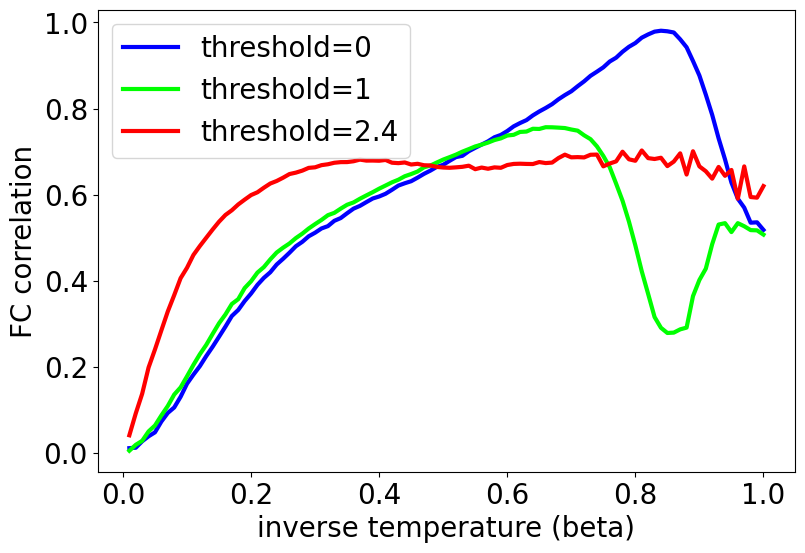

In [65]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
beta_np = depytorch(beta)
axs.plot( beta_np, depytorch(fc_corr[:,blue_thresh]), color=[0.0, 0.0, 1.0], label=f'threshold={threshold[blue_thresh]:.3g}', linewidth=linewidth )
axs.plot( beta_np, depytorch(fc_corr[:,green_thresh]), color=[0.0, 1.0, 0.0], label=f'threshold={threshold[green_thresh]:.3g}', linewidth=linewidth )
axs.plot( beta_np, depytorch(fc_corr[:,red_thresh]), color=[1.0, 0.0, 0.0], label=f'threshold={threshold[red_thresh]:.3g}', linewidth=linewidth )
axs.set_xlabel('inverse temperature (beta)')
axs.set_ylabel('FC correlation')
# axs.set_ylim([-0.1, 1.1])
axs.legend()
plt.show()

In [24]:
for threshold_index in [blue_thresh, green_thresh, red_thresh]:
    fc_corr_at_thresh = fc_corr[:,threshold_index]
    is_not_nan = torch.logical_not(  torch.logical_or( torch.isnan(fc_corr_at_thresh), torch.isinf(fc_corr_at_thresh) )  )
    beta_not_nan = beta[is_not_nan]
    fc_corr_not_nan = fc_corr_at_thresh[is_not_nan]
    best_beta_index = torch.argmax(fc_corr_not_nan)
    best_beta = beta_not_nan[best_beta_index]
    best_fc_corr = fc_corr_not_nan[best_beta_index]
    print(f'FC corr with threshold={threshold[threshold_index]:.3g} has best beta {best_beta:.3g}, best FC corr. {best_fc_corr:.3g}')

FC corr with threshold=0 has best beta 0.0135, best FC corr. 0.033
FC corr with threshold=1 has best beta 0.00775, best FC corr. 0.0077
FC corr with threshold=1.6 has best beta 1e-09, best FC corr. 0.0246


In [25]:
for threshold_index in [blue_thresh, green_thresh, red_thresh]:
    print_stats(name=f'FC corr with threshold={threshold[threshold_index]:.3g}', values=fc_corr[:,threshold_index])

The distribution of FC corr with threshold=0 values has median 0.000672 with 95% CI [-0.00577, 0.0279] and range [-0.00955, 0.033].
The distribution of FC corr with threshold=1 values has median nan with 95% CI [nan, nan] and range [nan, nan].
The distribution of FC corr with threshold=1.6 values has median nan with 95% CI [nan, nan] and range [nan, nan].


In [26]:
for threshold_index in range(num_thresholds):
    fc_corr_with_nans = fc_corr[:,threshold_index]
    fc_corr_no_nans = fc_corr_with_nans[torch.logical_not(  torch.logical_or( torch.isnan(fc_corr_with_nans), torch.isinf(fc_corr_with_nans) ) )]
    best_beta_index = fc_corr_no_nans.argmax()
    print( f'For threshold {threshold[threshold_index]:.3g}, best beta = {beta[best_beta_index]:.3g} max FC correlation = {fc_corr_no_nans[best_beta_index]:.3g}.' )

For threshold 0, best beta = 0.0135 max FC correlation = 0.033.
For threshold 0.1, best beta = 0.0118 max FC correlation = 0.0702.
For threshold 0.2, best beta = 0.012 max FC correlation = 0.067.


In [70]:
flip_rate = torch.load( os.path.join(file_dir, f'flip_rate_{param_string}.pt'), weights_only=False )
print( flip_rate.size() )

torch.Size([101, 31, 360])


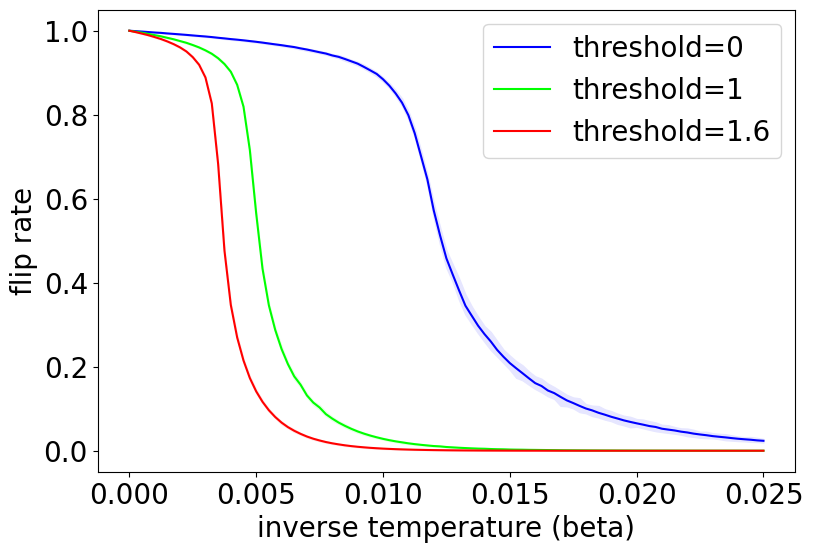

In [71]:
min_flip_rate = flip_rate.min(dim=-1).values
median_flip_rate = flip_rate.median(dim=-1).values
max_flip_rate = flip_rate.max(dim=-1).values
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
beta_np = depytorch(beta)
median_flip_rate_np = depytorch(median_flip_rate)
min_flip_rate_np = depytorch(min_flip_rate)
max_flip_rate_np = depytorch(max_flip_rate)
for thresh, c_triple in zip([blue_thresh, green_thresh, red_thresh], [ [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0] ]):
    axs.fill_between( beta_np, min_flip_rate_np[:,thresh], max_flip_rate_np[:,thresh], color=[0.9+0.1*c for c in c_triple])
    axs.plot( beta_np, median_flip_rate_np[:,thresh], color=c_triple, label=f'threshold={threshold[thresh]:.3g}' )
axs.set_xlabel('inverse temperature (beta)')
axs.set_ylabel('flip rate')
# axs.set_ylim([-0.1, 1.1])
axs.legend()
plt.show()

In [16]:
struct_corr_file = 'true_correlations_all_as_is_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000_signed_params_no_beta_permutations_1000000.pt'
struct_corr = torch.load( os.path.join(other_file_dir, struct_corr_file) )
print( struct_corr )

tensor([-0.0126,  0.0028,  0.0507,  0.0458,  0.0247,  0.0046,  0.0593, -0.0004,
        -0.0339,  0.0019,  0.0420,  0.3213, -0.0630, -0.0859, -0.0222, -0.0389,
        -0.0126, -0.1259, -0.1521, -0.1149, -0.1254, -0.1068, -0.1220, -0.2300],
       device='cuda:0')


In [17]:
node_features = torch.load( os.path.join(other_file_dir, 'node_features_all_as_is.pt') )
print( node_features.size() )

torch.Size([837, 360, 11])


In [18]:
edge_features = torch.load( os.path.join(other_file_dir, 'edge_features_all_as_is.pt') )
print( edge_features.size() )

torch.Size([837, 64620, 13])


In [19]:
model = torch.load( os.path.join(file_dir, 'ising_model_light_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000.pt') )
print( 'h', model.h.size() )
print( 'J', model.J.size() )

h torch.Size([5, 837, 360])
J torch.Size([5, 837, 360, 360])


In [20]:
h_flat = model.h.mean(dim=0).flatten()
h_np = depytorch(h_flat)
print( h_np.shape )
node_features_flat = node_features.flatten(start_dim=0, end_dim=1)
nf_std, nf_mean = torch.std_mean(node_features_flat, dim=0, keepdim=True)
node_features_z = (node_features_flat - nf_mean)/nf_std
node_features_np = depytorch(node_features_z)
print( node_features_np.shape )
node_feature_names = ['thickness', 'myelination', 'curvature', 'sulcus depth'] + ['mean SC'] + ['x', 'y', 'z'] + ['radius', 'inclination', 'azimuth']

(301320,)
(301320, 11)


In [21]:
h_np_and_1 = torch.stack(  ( h_flat, torch.ones_like(h_flat) ), dim=-1  )
lst_sq_result = torch.linalg.lstsq(h_np_and_1, node_features_z)
print(lst_sq_result)
node_features_z_pred = torch.matmul(h_np_and_1, lst_sq_result.solution)
print( node_features_z_pred.size() )
node_features_z_pred_np = depytorch(node_features_z_pred)

torch.return_types.linalg_lstsq(
solution=tensor([[-0.0150,  0.0342, -0.0064, -0.0183,  0.0295, -0.0009, -0.0257,  0.0230,
          0.0228, -0.0281, -0.0296],
        [-0.0693,  0.1585, -0.0295, -0.0848,  0.1364, -0.0040, -0.1189,  0.1067,
          0.1055, -0.1299, -0.1369]], device='cuda:0'),
residuals=tensor([298564.2500, 286928.2188, 300818.6250, 297195.7500, 290653.3125,
        301309.8750, 293219.0312, 294793.7188, 294946.1562, 291654.3750,
        290584.1250], device='cuda:0'),
rank=tensor([], device='cuda:0', dtype=torch.int64),
singular_values=tensor([], device='cuda:0'))
torch.Size([301320, 11])


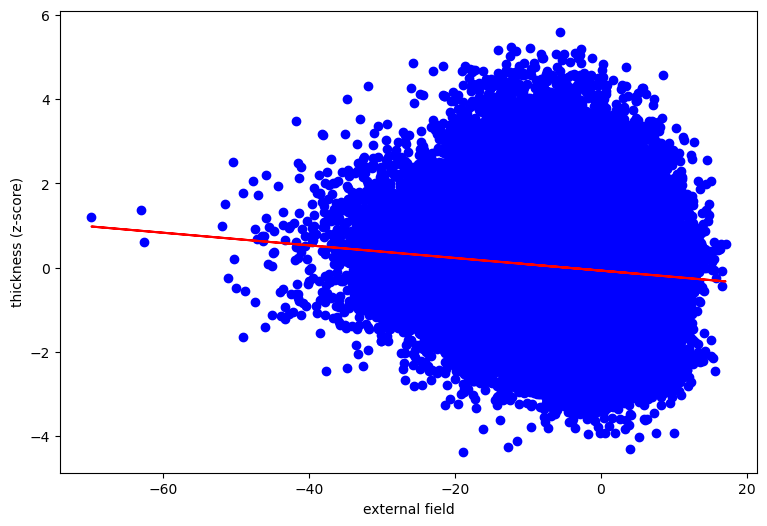

In [22]:
feature_index = 0
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.scatter( h_np, node_features_np[:,feature_index], color='blue' )
axs.plot( h_np, node_features_z_pred_np[:,feature_index], color='red' )
axs.set_xlabel('external field')
axs.set_ylabel(f'{node_feature_names[feature_index]} (z-score)')
# axs.set_ylim([-0.1, 1.1])
# axs.legend()
plt.show()

In [23]:
J = model.J
triu_rows, triu_cols = isingmodellight.get_triu_indices_for_products( num_nodes=J.size(dim=-1), device=device )
J_np = depytorch( J[:,:,triu_rows,triu_cols].mean(dim=0).flatten() )
print( J_np.shape )
edge_features_flat = edge_features.flatten(start_dim=0, end_dim=1)
ef_std, ef_mean = torch.std_mean(edge_features_flat, dim=0, keepdim=True)
edge_features_z = (edge_features_flat - ef_mean)/ef_std
edge_features_np = depytorch(edge_features_z)
print( edge_features_np.shape )
edge_feature_names = ['SC'] + [f'|{pname} difference|' for pname in node_feature_names] + ['distance']

(54086940,)
(54086940, 13)


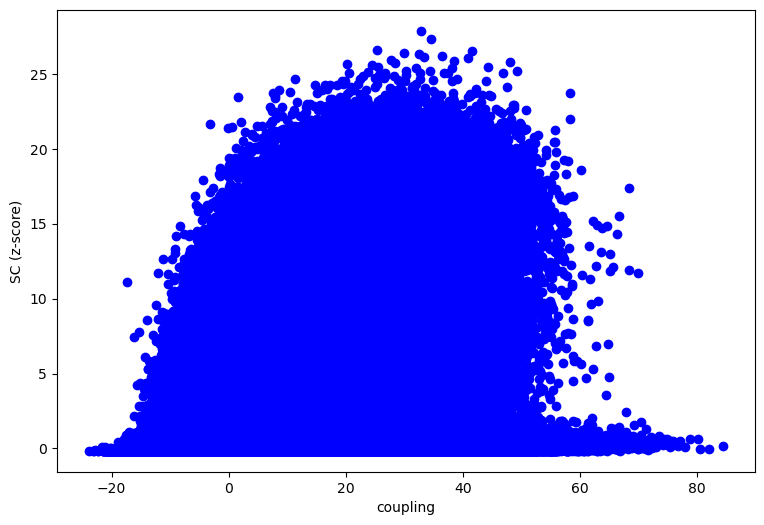

In [24]:
feature_index = 0
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.scatter( J_np, edge_features_np[:,feature_index], color='blue' )
axs.set_xlabel('coupling')
axs.set_ylabel(f'{edge_feature_names[feature_index]} (z-score)')
# axs.set_ylim([-0.1, 1.1])
# axs.legend()
plt.show()

In [25]:
num_thresholds = 31
min_threshold = 0.0
max_threshold = 3.0
num_betas = 101
min_beta = 1e-10
max_beta = 0.05
param_string = f'ising_model_light_group_thresholds_{num_thresholds}_min_{min_threshold:.3g}_max_{max_threshold:.3g}_betas_{num_betas}_min_{min_beta:.3g}_max_{max_beta:.3g}_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_test_length_120000'

In [26]:
fc_corr = torch.load( os.path.join(file_dir, f'fc_corr_{param_string}.pt') )
print( fc_corr.size() )

torch.Size([101, 31])


In [27]:
thresholds = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=fc_corr.dtype, device=fc_corr.device)

In [28]:
blue_index = get_closest_match(values=thresholds, target=0.0)
green_index = get_closest_match(values=thresholds, target=1.0)
red_index = get_closest_match(values=thresholds, target=2.4)
selected_indices = [blue_index, green_index, red_index]
print( torch.min(fc_corr[:,selected_indices], dim=0).values )
print( torch.max(fc_corr[:,selected_indices], dim=0).values )

tensor([0.9857, 0.9452, 0.0567], device='cuda:0')
tensor([0.9992, 0.9888, 0.0808], device='cuda:0')


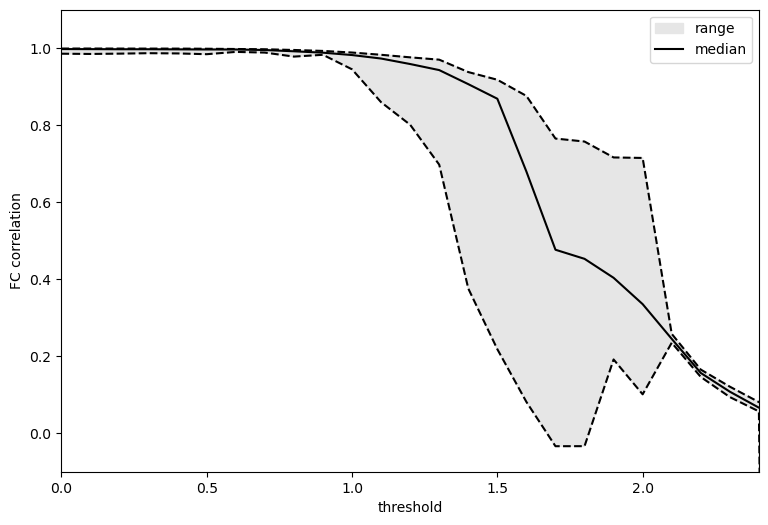

In [32]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
thresholds_np = depytorch(thresholds)
min_fc_corr = depytorch( torch.min(fc_corr, dim=0).values )
max_fc_corr = depytorch( torch.max(fc_corr, dim=0).values )
median_fc_corr = depytorch( torch.median(fc_corr, dim=0).values )
axs.fill_between(thresholds_np, min_fc_corr, max_fc_corr, color=[0.9, 0.9, 0.9], label='range')
axs.plot(thresholds_np, min_fc_corr, color='black', linestyle='--')
axs.plot(thresholds_np, max_fc_corr, color='black', linestyle='--')
axs.plot(thresholds_np, median_fc_corr, color='black', label='median')
axs.set_xlabel('threshold')
axs.set_ylabel('FC correlation')
axs.set_xlim([0, 2.4])
axs.set_ylim([-0.1, 1.1])
axs.legend()
plt.show()